# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Exploration:
    1. Observe datatypes
    2. Find percentage of NaN values

In [4]:
customers.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [5]:
null_count = []
for i in customers:
    value = customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(customers.columns[i], (null_count[i]/customers.shape[0] * 100)))

Percentage of null values in each column:
LNR: 0.00%
AGER_TYP: 0.00%
AKT_DAT_KL: 24.31%
ALTER_HH: 24.31%
ALTER_KIND1: 93.86%
ALTER_KIND2: 97.34%
ALTER_KIND3: 99.33%
ALTER_KIND4: 99.88%
ALTERSKATEGORIE_FEIN: 27.05%
ANZ_HAUSHALTE_AKTIV: 26.05%
ANZ_HH_TITEL: 27.19%
ANZ_KINDER: 24.31%
ANZ_PERSONEN: 24.31%
ANZ_STATISTISCHE_HAUSHALTE: 26.05%
ANZ_TITEL: 24.31%
ARBEIT: 26.34%
BALLRAUM: 26.07%
CAMEO_DEU_2015: 26.31%
CAMEO_DEUG_2015: 26.31%
CAMEO_INTL_2015: 26.31%
CJT_GESAMTTYP: 1.68%
CJT_KATALOGNUTZER: 1.68%
CJT_TYP_1: 1.68%
CJT_TYP_2: 1.68%
CJT_TYP_3: 1.68%
CJT_TYP_4: 1.68%
CJT_TYP_5: 1.68%
CJT_TYP_6: 1.68%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 24.89%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV

In [6]:
for i in customers:
    print(i)
    print(customers[i].unique())

LNR
[  9626   9628 143872 ... 148813 148852 148883]
AGER_TYP
[ 2 -1  1  0  3]
AKT_DAT_KL
[ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]
ALTER_HH
[10. 11.  6.  8. 20.  5. 14. 21. 15. 17.  0. 19.  9. 12. 13. nan 18.  7.
 16.  4.  2.  3.]
ALTER_KIND1
[nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]
ALTER_KIND2
[nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]
ALTER_KIND3
[nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]
ALTER_KIND4
[nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]
ALTERSKATEGORIE_FEIN
[10. nan  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21.
 25. 20. 24.  5.  2. 22.  3. 23.]
ANZ_HAUSHALTE_AKTIV
[  1.  nan   0.   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.
  55.   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.
  47.  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.
  46.  24.  33.  51. 523. 104. 101.  59.  44.  38.  61.  69.  28.  48.
  40.  39. 145. 107.  32.  76. 11

[ 5. nan  3.  4.  2.  1.  9.]
KBA05_MAXBJ
[ 2. nan  4.  1.  3.  9.]
KBA05_MAXHERST
[ 2. nan  4.  3.  1.  5.  9.]
KBA05_MAXSEG
[ 3. nan  2.  1.  4.  9.]
KBA05_MAXVORB
[ 2. nan  1.  3.  9.]
KBA05_MOD1
[ 2. nan  0.  1.  4.  3.  9.]
KBA05_MOD2
[ 4. nan  3.  5.  2.  1.  9.]
KBA05_MOD3
[ 3. nan  4.  5.  1.  2.  9.]
KBA05_MOD4
[ 4. nan  3.  0.  1.  2.  5.  9.]
KBA05_MOD8
[ 2. nan  1.  0.  3.  9.]
KBA05_MODTEMP
[ 2. nan  3.  4.  1.  5.  6.]
KBA05_MOTOR
[ 4. nan  2.  3.  1.  9.]
KBA05_MOTRAD
[ 1. nan  0.  2.  3.  9.]
KBA05_SEG1
[ 1. nan  3.  0.  2.  9.]
KBA05_SEG10
[ 2. nan  4.  1.  3.  0.  9.]
KBA05_SEG2
[ 3. nan  2.  4.  1.  5.  9.]
KBA05_SEG3
[ 2. nan  4.  3.  5.  1.  9.]
KBA05_SEG4
[ 3. nan  4.  2.  5.  1.  9.]
KBA05_SEG5
[ 3. nan  1.  0.  4.  2.  9.]
KBA05_SEG6
[ 1. nan  0.  9.]
KBA05_SEG7
[ 0. nan  3.  1.  2.  9.]
KBA05_SEG8
[ 1. nan  2.  0.  3.  9.]
KBA05_SEG9
[ 2. nan  1.  0.  3.  9.]
KBA05_VORB0
[ 4. nan  3.  2.  5.  1.  9.]
KBA05_VORB1
[ 3. nan  4.  1.  2.  5.  9.]
KBA05_VORB2
[ 2. na

### Data Processing

In [7]:
def preprocessing (dataframe):
    dataframe = dataframe.copy()
    dataframe.drop_duplicates(keep = 'first', inplace = True)
    dataframe.replace(-1, float('NaN'), inplace=True)
    dataframe.replace(0, float('NaN'), inplace=True)
    
    
    new_list = []

    for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'):
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('int64')
            

            new_list.append(dataframe.columns[i])
            
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].mode().iloc[0])
    

    dataframe.drop(['LNR'], axis=1, inplace=True)
    
    return dataframe

In [8]:
cleaned_customers = preprocessing(customers)
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
1,2.0,9.0,11.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
2,2.0,1.0,6.0,18.0,18.0,18.0,18.0,10.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
3,1.0,1.0,8.0,18.0,18.0,18.0,18.0,8.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
4,2.0,1.0,20.0,18.0,18.0,18.0,18.0,14.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [9]:
# Dropping specific columns with greater than 60% NaN values
cleaned_customers.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'], axis=1, inplace=True)

### Data Processing Confirmation

In [10]:
null_count = []
for i in cleaned_customers:
    value = cleaned_customers[i].isnull().sum()
    null_count.append(value)

print("Percentage of null values in each column:")
for i in range(len(null_count)-1):
    print("{}: {:.2f}%".format(cleaned_customers.columns[i], (null_count[i]/cleaned_customers.shape[0] * 100)))

Percentage of null values in each column:
AGER_TYP: 0.00%
AKT_DAT_KL: 0.00%
ALTER_HH: 0.00%
ALTERSKATEGORIE_FEIN: 0.00%
ANZ_HAUSHALTE_AKTIV: 0.00%
ANZ_HH_TITEL: 0.00%
ANZ_KINDER: 0.00%
ANZ_PERSONEN: 0.00%
ANZ_STATISTISCHE_HAUSHALTE: 0.00%
ANZ_TITEL: 0.00%
ARBEIT: 0.00%
BALLRAUM: 0.00%
CAMEO_DEU_2015: 0.00%
CAMEO_DEUG_2015: 0.00%
CAMEO_INTL_2015: 0.00%
CJT_GESAMTTYP: 0.00%
CJT_KATALOGNUTZER: 0.00%
CJT_TYP_1: 0.00%
CJT_TYP_2: 0.00%
CJT_TYP_3: 0.00%
CJT_TYP_4: 0.00%
CJT_TYP_5: 0.00%
CJT_TYP_6: 0.00%
D19_BANKEN_ANZ_12: 0.00%
D19_BANKEN_ANZ_24: 0.00%
D19_BANKEN_DATUM: 0.00%
D19_BANKEN_DIREKT: 0.00%
D19_BANKEN_GROSS: 0.00%
D19_BANKEN_LOKAL: 0.00%
D19_BANKEN_OFFLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_DATUM: 0.00%
D19_BANKEN_ONLINE_QUOTE_12: 0.00%
D19_BANKEN_REST: 0.00%
D19_BEKLEIDUNG_GEH: 0.00%
D19_BEKLEIDUNG_REST: 0.00%
D19_BILDUNG: 0.00%
D19_BIO_OEKO: 0.00%
D19_BUCH_CD: 0.00%
D19_DIGIT_SERV: 0.00%
D19_DROGERIEARTIKEL: 0.00%
D19_ENERGIE: 0.00%
D19_FREIZEIT: 0.00%
D19_GARTEN: 0.00%
D19_GESAMT_ANZ

In [11]:
cleaned_population = preprocessing(azdias)
cleaned_population.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'], axis=1, inplace=True)
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,18.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
1,2.0,9.0,18.0,21.0,11.0,1.0,1.0,2.0,12.0,1.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2.0,9.0,17.0,17.0,10.0,1.0,1.0,1.0,7.0,1.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,13.0,1.0,1.0,1.0,1.0,2.0,1.0,...,2.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
4,2.0,1.0,20.0,14.0,3.0,1.0,1.0,4.0,3.0,1.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [12]:
#    The preferred method for imputation is KNN Imputation.
#    However, due to the large dataset, it is computationally expensive. 
#    The choice was made not to include KNN imputation, and opt for 
#    imputation using median values. 
#    
#    Below is the code that would've been used if the dataset weren't too
#    large. 

#from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
# K Nearest Neighbours algorithm is used to replace values with its nearest neighbours - or most similar row data
#cleaned_customers = pd.DataFrame(KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean').fit(cleaned_customers).transform(cleaned_customers), columns = cleaned_customers.columns)

In [13]:
# Code for viewing distinct values within a column

#for i in cleaned_customers:
#    print(cleaned_customers[i].unique())

# PCA 

### Customers PCA and Kmeans clustering

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
PCA_components = pd.DataFrame(X_df)
pca.explained_variance_ratio_

array([5.86210617e-01, 4.09873743e-01, 8.52747947e-04, 5.59697268e-04,
       3.68556155e-04, 3.47146411e-04, 2.88657403e-04, 2.57461623e-04,
       2.00202648e-04, 1.29952229e-04, 1.12025926e-04, 8.48363220e-05,
       5.19219294e-05, 3.44007234e-05, 2.76663048e-05, 2.65267170e-05,
       2.49538628e-05, 2.25232979e-05, 2.03617533e-05, 1.76976130e-05])

([<matplotlib.axis.XTick at 0x2a46067d0b8>,
 <a list of 20 Text xticklabel objects>)

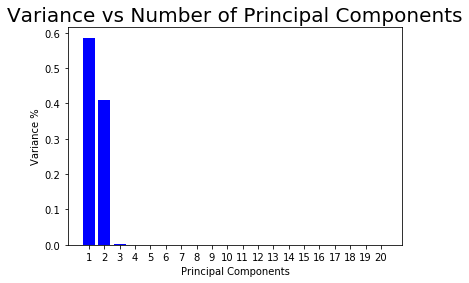

In [15]:
from sklearn.preprocessing import StandardScaler

pc_range = range(1, pca.n_components_+1)
plt.title("Variance vs Number of Principal Components", size=20)
plt.bar(pc_range, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(pc_range)

In [16]:
pca = PCA(n_components=2)
X_df = pca.fit(cleaned_customers).transform(cleaned_customers)
pca.explained_variance_ratio_

array([0.58621062, 0.40987374])

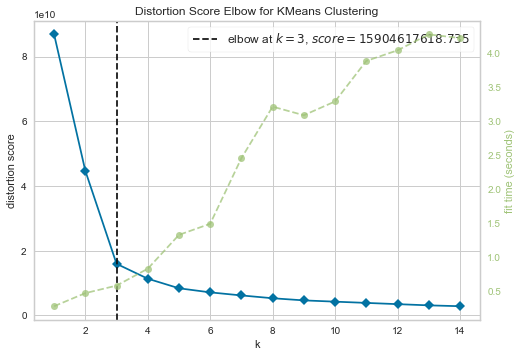

In [17]:
from sklearn.cluster import KMeans # Importing K-Means algorithm 
from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
from sklearn.linear_model import LinearRegression # Importing Linear Regression model 
from sklearn.metrics import mean_squared_error # Evaluation metric 
from sklearn.model_selection import train_test_split # Preprocessing for training and testing data splits 

from yellowbrick.cluster import KElbowVisualizer # Importing Elbow Method Library

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15)) # Loop through model to find ideal number of clusters within the data

visualizer.fit(PCA_components)
visualizer.show()

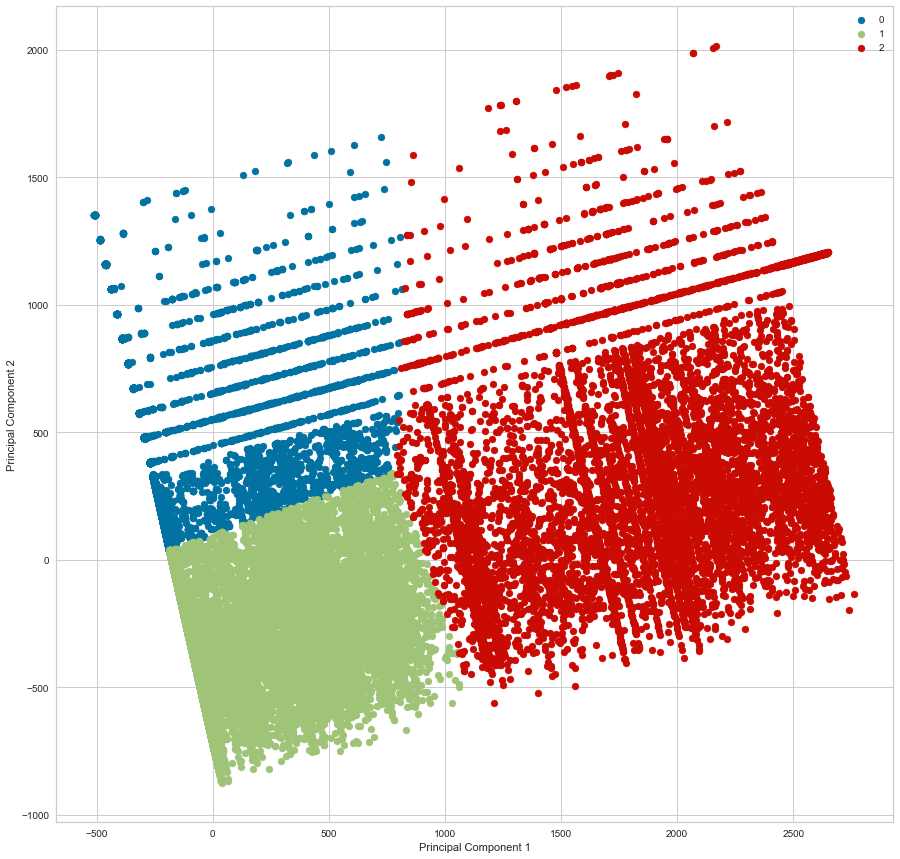

In [18]:
from sklearn.cluster import KMeans
k_means_model = KMeans(n_clusters = 3, init = "k-means++")
y2 = k_means_model.fit_predict(X_df)
plt.figure(figsize=(15,15))
k_means_pred = k_means_model.fit_predict(X_df)
uniq = np.unique(k_means_pred)
for i in uniq:
  plt.scatter(X_df[k_means_pred == i , 0] , X_df[k_means_pred == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [19]:
cleaned_customers['cluster'] = k_means_model.labels_ # Adding extra column to the location dataframe to allocate data to separate groups
cleaned_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,3,1,0,1.0,1,4,0
1,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,6.0,9.0,3.0,3,2,1,1.0,1,4,0
2,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,9.0,2.0,3,1,0,1.0,2,4,1
3,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,6.0,9.0,7.0,1,0,0,1.0,1,4,1
4,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,2.0,9.0,3.0,1,2,0,1.0,1,3,1


In [20]:
array = k_means_model.cluster_centers_
array = array.astype(int)
array

array([[-261,  442],
       [ -16, -334],
       [1847,  357]])

In [21]:
dataframe_cluster_0 = cleaned_customers[cleaned_customers['cluster'] == 0]
dataframe_cluster_1 = cleaned_customers[cleaned_customers['cluster'] == 1]
dataframe_cluster_2 = cleaned_customers[cleaned_customers['cluster'] == 2]

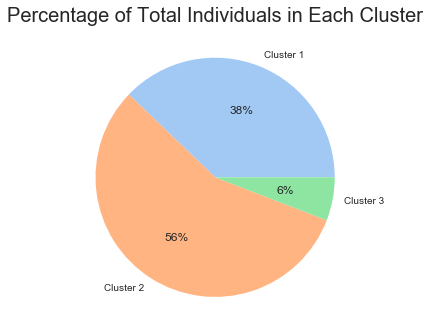

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = [len(dataframe_cluster_0), len(dataframe_cluster_1), len(dataframe_cluster_2)]
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title('Percentage of Total Individuals in Each Cluster', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc_df = cleaned_customers.copy()
rfc_y = rfc_df.pop('cluster')
rfc_X = rfc_df[:]
rfc_X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,10.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
1,2.0,9.0,11.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,...,3.0,6.0,9.0,3.0,3,2,1,1.0,1,4
2,2.0,1.0,6.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
3,1.0,1.0,8.0,8.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,6.0,9.0,7.0,1,0,0,1.0,1,4
4,2.0,1.0,20.0,14.0,7.0,1.0,1.0,4.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [24]:
rfc_y.head()

0    0
1    0
2    1
3    1
4    1
Name: cluster, dtype: int32

In [25]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
rfc_X_train, rfc_X_test, rfc_y_train, rfc_y_test = train_test_split(rfc_X, rfc_y)
from sklearn.svm import SVC
rfc = RandomForestClassifier()
rfc.fit(rfc_X_train, rfc_y_train)
rfc_pred = rfc.predict(rfc_X_test)
# Add pipeline for grid search to optimize model
from sklearn.metrics import accuracy_score
print ("Accuracy : {:.2f}%".format(accuracy_score(rfc_y_test, rfc_pred)*100))

Accuracy : 99.73%


In [26]:
rfc_array = rfc.feature_importances_

In [27]:
#df = pd.DataFrame(array.reshape(1, 368), columns=X.columns)
rfc_importances = []
count = 0
for i in rfc_array:
    rfc_importances.append([i, rfc_X.columns[count]])
    count += 1

In [28]:
rfc_importances.sort(reverse=True)
rfc_labels = []
rfc_values = []
for i in rfc_importances[0:20]:
    rfc_labels.append(i[1])
    rfc_values.append(i[0])

rfc_importances[0:20]

[[0.14550225657400312, 'KBA13_ANZAHL_PKW'],
 [0.09566524970976294, 'EINGEFUEGT_AM'],
 [0.05783410777035989, 'CAMEO_DEU_2015'],
 [0.0421993609304724, 'CAMEO_INTL_2015'],
 [0.036349424954380184, 'KBA13_HHZ'],
 [0.03482389887421054, 'D19_LETZTER_KAUF_BRANCHE'],
 [0.033983050479265066, 'KBA05_MODTEMP'],
 [0.0338461046406259, 'PLZ8_HHZ'],
 [0.028000851196979676, 'MIN_GEBAEUDEJAHR'],
 [0.027509656430267967, 'CAMEO_DEUG_2015'],
 [0.02586494228529676, 'KBA05_HERSTTEMP'],
 [0.025027359832298215, 'FINANZ_UNAUFFAELLIGER'],
 [0.021543505973204112, 'PLZ8_GBZ'],
 [0.020709629635279562, 'KBA13_GBZ'],
 [0.01600087622295882, 'FINANZ_ANLEGER'],
 [0.015391505154033142, 'SEMIO_VERT'],
 [0.01504088654287908, 'KOMBIALTER'],
 [0.012810050415287653, 'CJT_TYP_1'],
 [0.010675134664574952, 'SEMIO_REL'],
 [0.010559140350347463, 'OST_WEST_KZ']]

C:\Users\Daniel\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

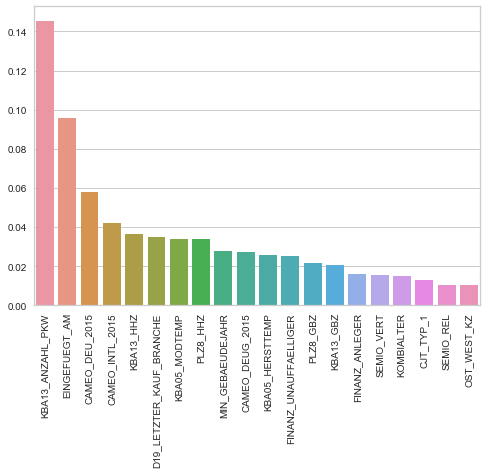

In [29]:
sns.barplot(rfc_labels, rfc_values)
plt.xticks(rotation=90)

Important: There is no background information on 'EINGEFUEGT_AM', 'KOMBIALTER', 'KBA05_HERSTTEMP', 'MIN_GEBAEUDEJAHR' 'KBA05_MODTEMP'. These seem to play an important role in the factors influencing cluster segmentation. It's not possible to decifer what these feature are related to and how they are represented. 

#OST_WEST_KZ
#CAMEO_DEUG_2015
#PLZ8_HHZ

# Exploratory Data Analysis

C:\Users\Daniel\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


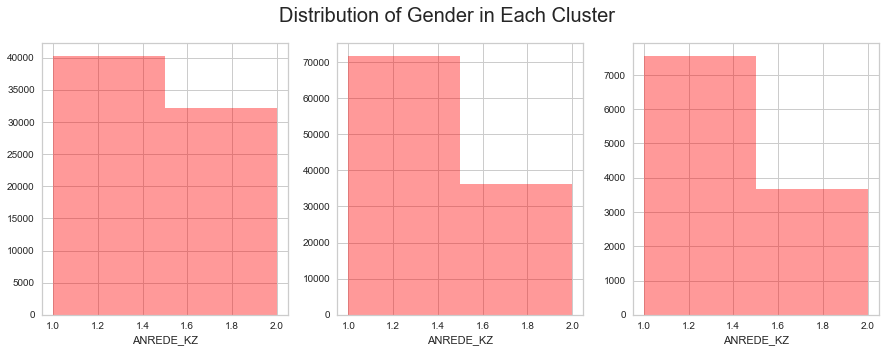

In [30]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Gender in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['ANREDE_KZ'],  ax=axes[0], color ='red', bins = 2, kde = False)

sns.distplot(dataframe_cluster_1['ANREDE_KZ'],  ax=axes[1], color ='red', bins = 2, kde = False)

sns.distplot(dataframe_cluster_2['ANREDE_KZ'],  ax=axes[2], color ='red', bins = 2, kde = False)

### Observations:
- The majority of customers are male. 
- The first cluster has a more even distribution of males to females as compared to the other two clusters. 

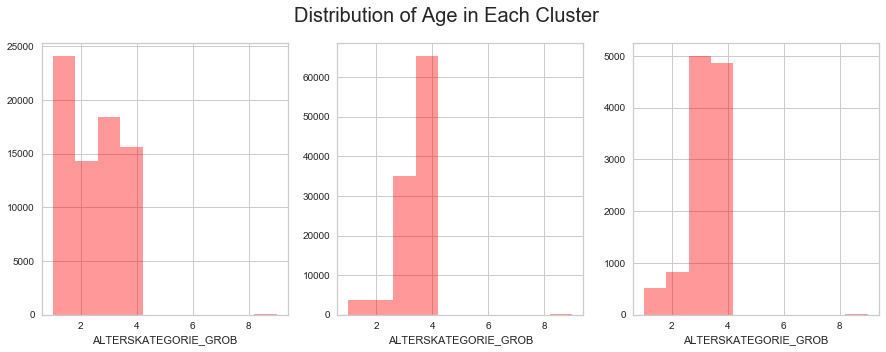

In [31]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Distribution of Age in Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['ALTERSKATEGORIE_GROB'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['ALTERSKATEGORIE_GROB'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['ALTERSKATEGORIE_GROB'],  ax=axes[2], color ='red', bins = 10, kde = False)

### Oberservations:
- The first cluster has a younger population with individuals falling into the category of less than 30 years of age, and between the ages of 30 and 45. 
- The second cluster tends to have a larger population of middle aged individuals ranging from 46 - 60 years of age. 
- The third cluster has the largest percentage of individuals who are over the age of 60 years of age

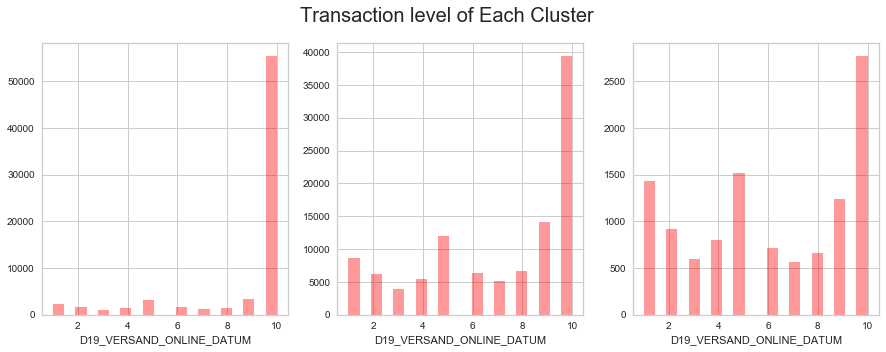

In [32]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Transaction level of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_DATUM'],  ax=axes[0], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_DATUM'],  ax=axes[1], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_DATUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

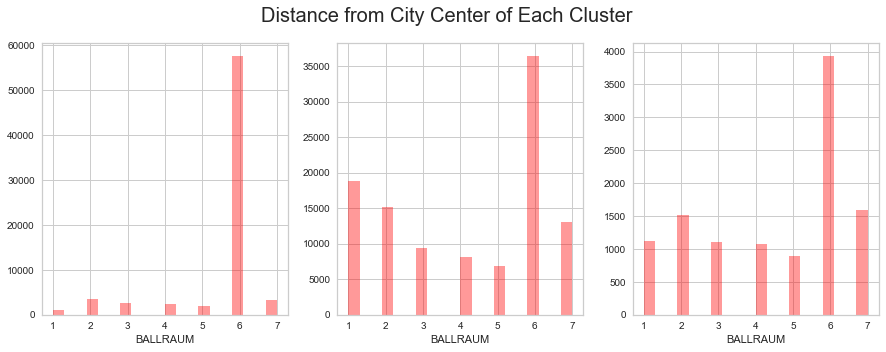

In [33]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Distance from City Center of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['BALLRAUM'],  ax=axes[0], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_1['BALLRAUM'],  ax=axes[1], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_2['BALLRAUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

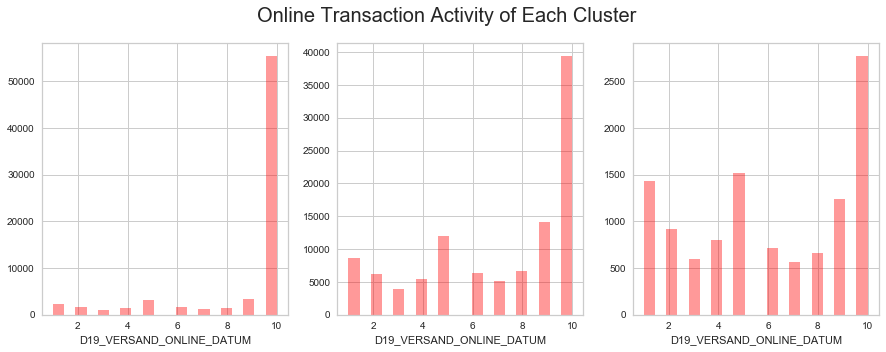

In [34]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Online Transaction Activity of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_DATUM'],  ax=axes[0], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_DATUM'],  ax=axes[1], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_DATUM'],  ax=axes[2], color ='red', bins = 20, kde = False)

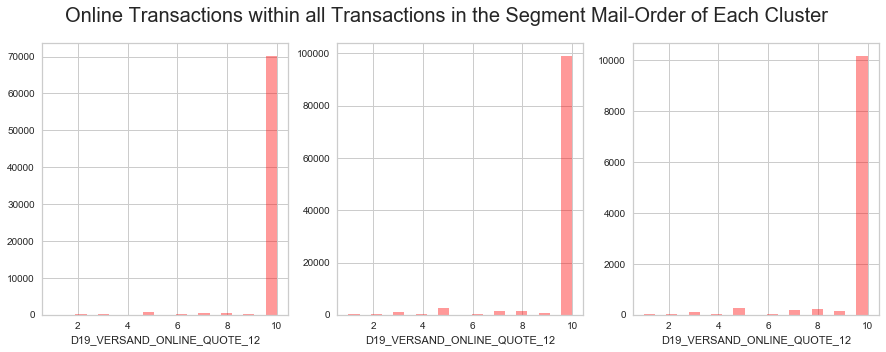

In [35]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Online Transactions within all Transactions in the Segment Mail-Order of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[0], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_1['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[1], color ='red', bins = 20, kde = False)

sns.distplot(dataframe_cluster_2['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[2], color ='red', bins = 20, kde = False)

#sns.distplot(dataframe_cluster_3['D19_VERSAND_ONLINE_QUOTE_12'],  ax=axes[1, 1], color ='red', bins = 20, kde = False)

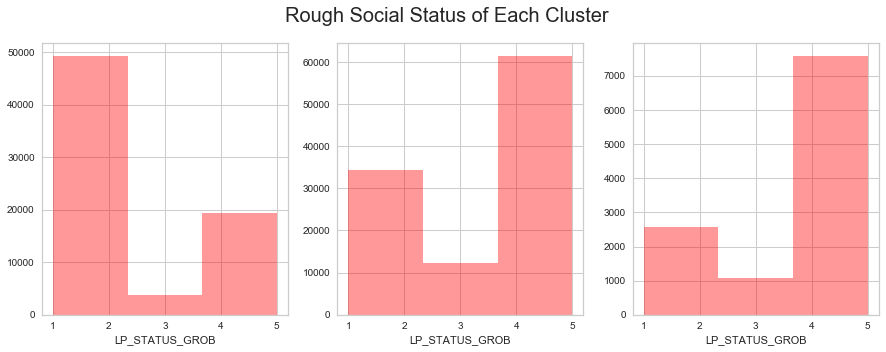

In [36]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Rough Social Status of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['LP_STATUS_GROB'],  ax=axes[0], color ='red', bins = 3, kde = False)

sns.distplot(dataframe_cluster_1['LP_STATUS_GROB'],  ax=axes[1], color ='red', bins = 3, kde = False)

sns.distplot(dataframe_cluster_2['LP_STATUS_GROB'],  ax=axes[2], color ='red', bins = 3, kde = False)

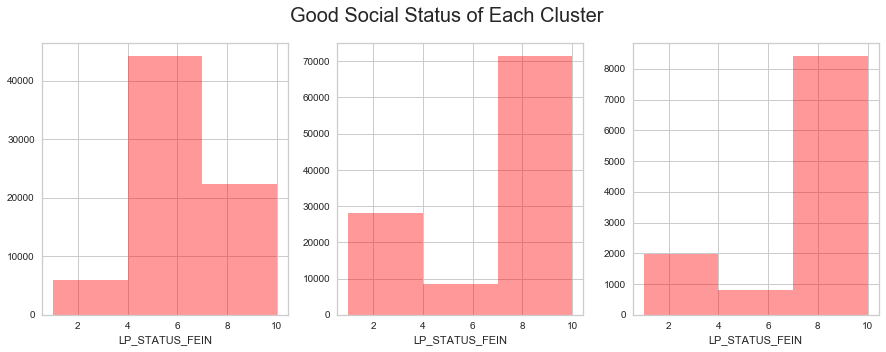

In [37]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Good Social Status of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['LP_STATUS_FEIN'],  ax=axes[0], color ='red', bins = 3, kde = False)

sns.distplot(dataframe_cluster_1['LP_STATUS_FEIN'],  ax=axes[1], color ='red', bins = 3, kde = False)

sns.distplot(dataframe_cluster_2['LP_STATUS_FEIN'],  ax=axes[2], color ='red', bins = 3, kde = False)

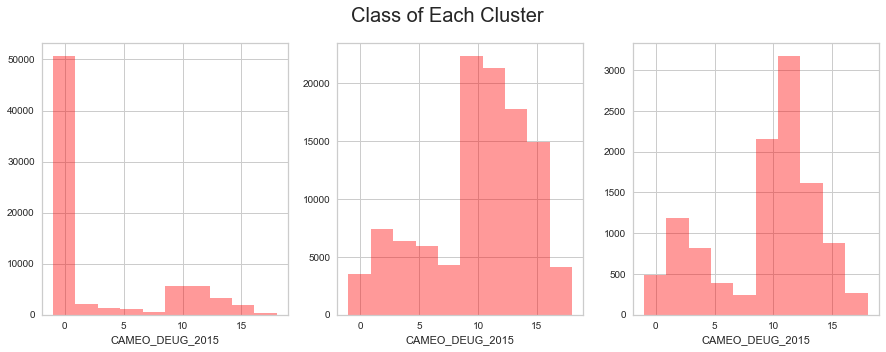

In [38]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Class of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['CAMEO_DEUG_2015'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['CAMEO_DEUG_2015'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['CAMEO_DEUG_2015'],  ax=axes[2], color ='red', bins = 10, kde = False)


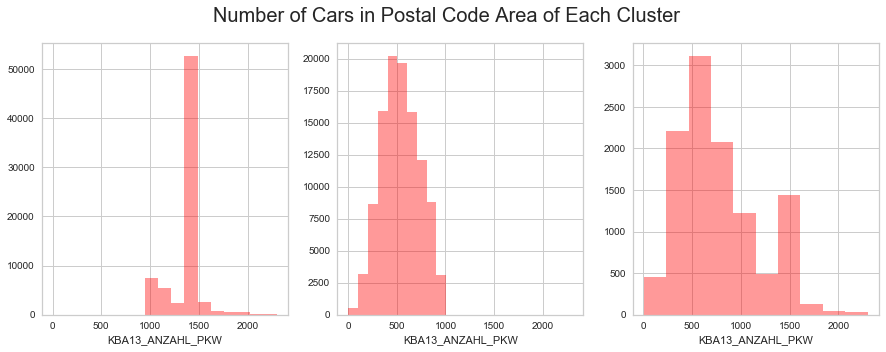

In [39]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Number of Cars in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_ANZAHL_PKW'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['KBA13_ANZAHL_PKW'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['KBA13_ANZAHL_PKW'],  ax=axes[2], color ='red', bins = 10, kde = False)

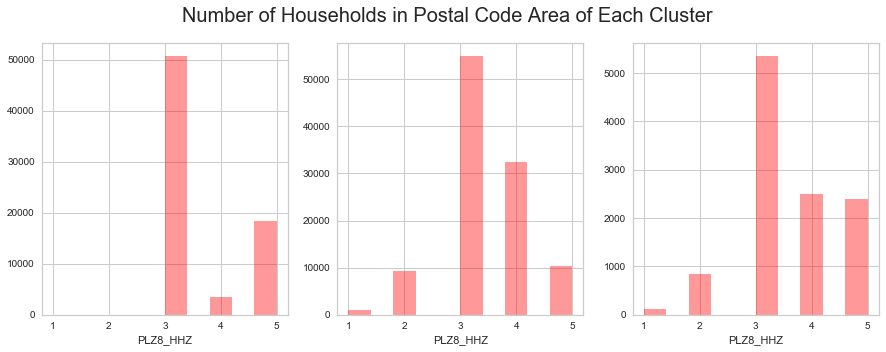

In [40]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Number of Households in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_HHZ'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['PLZ8_HHZ'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['PLZ8_HHZ'],  ax=axes[2], color ='red', bins = 10, kde = False)

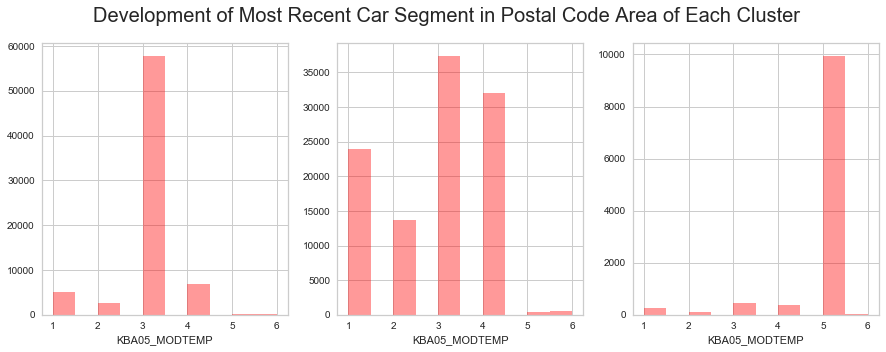

In [41]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Development of Most Recent Car Segment in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA05_MODTEMP'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['KBA05_MODTEMP'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['KBA05_MODTEMP'],  ax=axes[2], color ='red', bins = 10, kde = False)

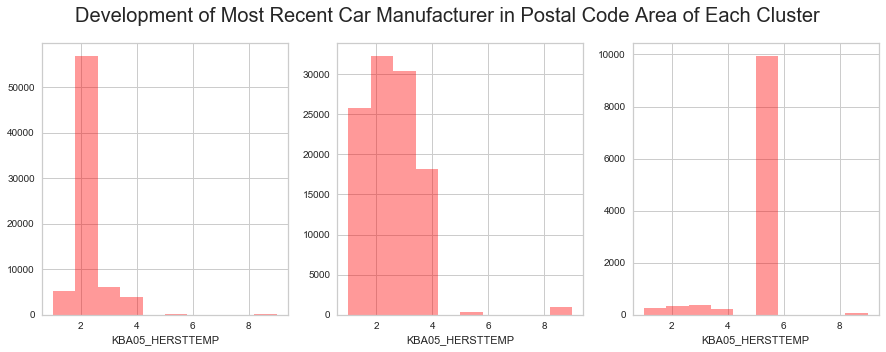

In [42]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
figure.suptitle('Development of Most Recent Car Manufacturer in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA05_HERSTTEMP'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['KBA05_HERSTTEMP'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['KBA05_HERSTTEMP'],  ax=axes[2], color ='red', bins = 10, kde = False)

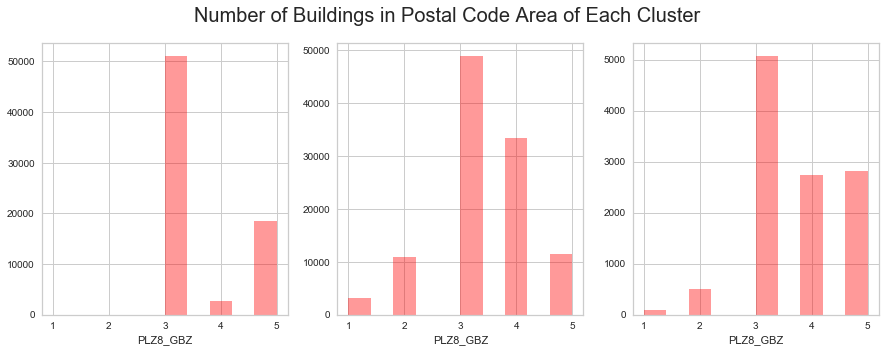

In [43]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Number of Buildings in Postal Code Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['PLZ8_GBZ'],  ax=axes[0], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_1['PLZ8_GBZ'],  ax=axes[1], color ='red', bins = 10, kde = False)

sns.distplot(dataframe_cluster_2['PLZ8_GBZ'],  ax=axes[2], color ='red', bins = 10, kde = False)

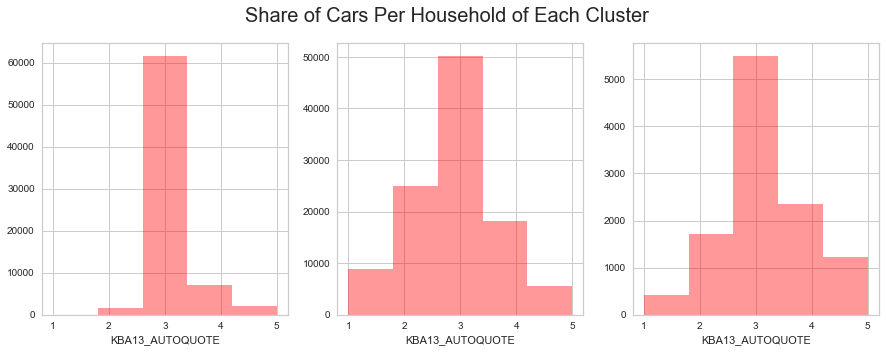

In [44]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Share of Cars Per Household of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_AUTOQUOTE'],  ax=axes[0], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_1['KBA13_AUTOQUOTE'],  ax=axes[1], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_2['KBA13_AUTOQUOTE'],  ax=axes[2], color ='red', bins = 5, kde = False)

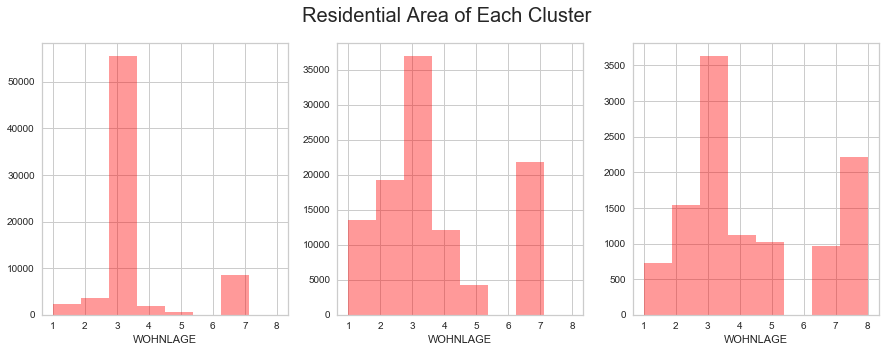

In [45]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Residential Area of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['WOHNLAGE'],  ax=axes[0], color ='red', bins = 8, kde = False)

sns.distplot(dataframe_cluster_1['WOHNLAGE'],  ax=axes[1], color ='red', bins = 8, kde = False)

sns.distplot(dataframe_cluster_2['WOHNLAGE'],  ax=axes[2], color ='red', bins = 8, kde = False)

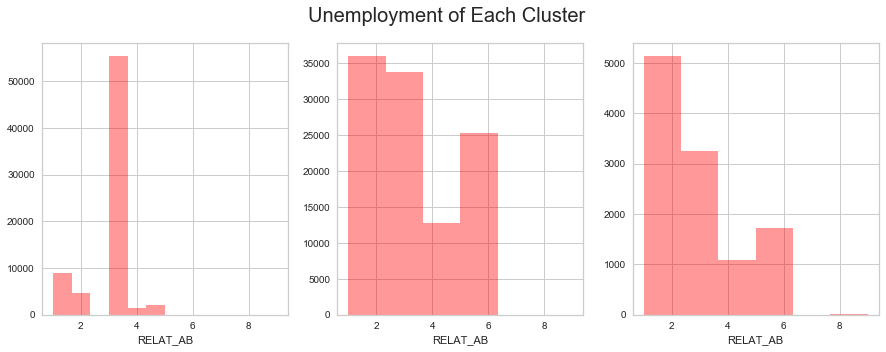

In [46]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Unemployment of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['RELAT_AB'],  ax=axes[0], color ='red', bins = 6, kde = False)

sns.distplot(dataframe_cluster_1['RELAT_AB'],  ax=axes[1], color ='red', bins = 6, kde = False)

sns.distplot(dataframe_cluster_2['RELAT_AB'],  ax=axes[2], color ='red', bins = 6, kde = False)

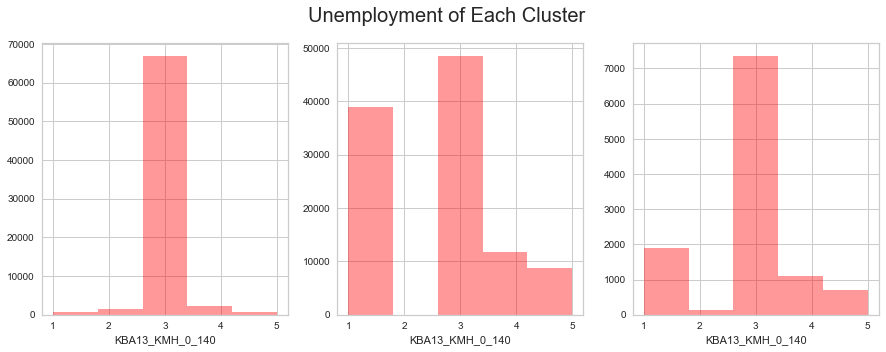

In [47]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('Unemployment of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['KBA13_KMH_0_140'],  ax=axes[0], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_1['KBA13_KMH_0_140'],  ax=axes[1], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_2['KBA13_KMH_0_140'],  ax=axes[2], color ='red', bins = 5, kde = False)

C:\Users\Daniel\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


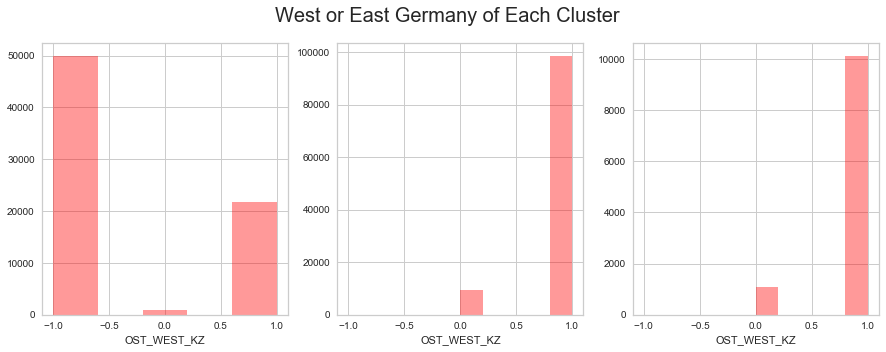

In [83]:
figure, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
figure.suptitle('West or East Germany of Each Cluster', fontsize=20)

sns.distplot(dataframe_cluster_0['OST_WEST_KZ'],  ax=axes[0], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_1['OST_WEST_KZ'],  ax=axes[1], color ='red', bins = 5, kde = False)

sns.distplot(dataframe_cluster_2['OST_WEST_KZ'],  ax=axes[2], color ='red', bins = 5, kde = False)

In [48]:
filtered_customers = cleaned_customers.filter(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 
                                       'D19_BANKEN_ANZ_24',
                          'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                           'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
                          'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
                          'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                          'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                          'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                          'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
                           'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
                          'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
                           'ONLINE_AFFINITAET', 'REGIOTYP'])

for i in filtered_customers:
        filtered_customers[i] = filtered_customers[i].astype(int)

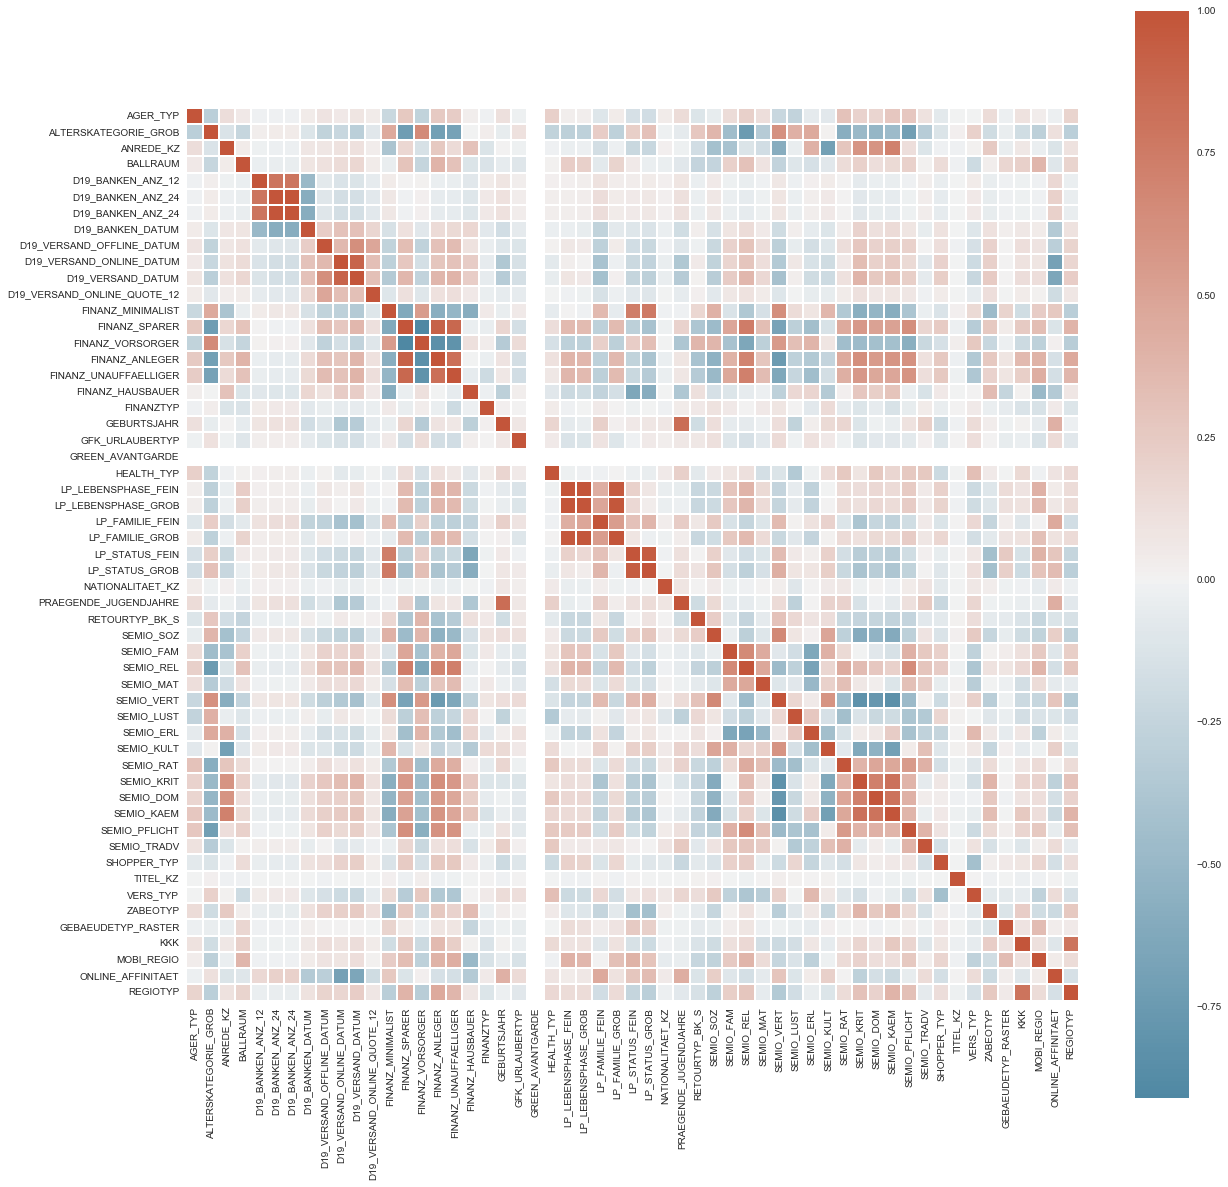

In [49]:
#sns.set_theme(style="white")

# Obtaining correlation matrix
#corr_df = filtered_customers.copy() #.drop(['cluster'], axis=1)
corr = filtered_customers.corr()

# Matplotlib graph setup 
f, ax = plt.subplots(figsize=(20, 20))

# Generating Seaplot colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 1}, fmt=".2f")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [50]:
train_csv = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train_csv.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [51]:
y = train_csv.pop('RESPONSE')
X = train_csv[:]
X = preprocessing(X)
X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,8.0,18.0,17.0,18.0,13.0,8.0,15.0,1.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1.0,4.0,13.0,18.0,17.0,18.0,13.0,13.0,1.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1.0,1.0,9.0,18.0,17.0,18.0,13.0,7.0,1.0,1.0,...,1.0,6.0,4.0,2.0,6.0,9.0,2.0,3,1,4
3,2.0,1.0,6.0,18.0,17.0,18.0,13.0,6.0,4.0,1.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,2.0,1.0,9.0,18.0,17.0,18.0,13.0,9.0,53.0,1.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [52]:
print(y.count())
print(y.nunique())
print(y.head())

def response_counter(response_array):
    number_of_yes = 0 
    number_of_no = 0
    for i in response_array:
        if i == 1:
            number_of_yes += 1
        else:
            number_of_no += 1
    return number_of_yes, number_of_no

number_of_yes, number_of_no = response_counter(y)

42962
2
0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64


In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_df = pca.fit(X).transform(X)
pca.explained_variance_ratio_

array([6.82161837e-01, 3.10646893e-01, 1.59111134e-03, 9.68662950e-04,
       7.65216620e-04, 5.77731449e-04, 5.18850287e-04, 4.53759269e-04,
       3.71219388e-04, 2.04895948e-04, 1.96769743e-04, 1.35983329e-04,
       9.84200124e-05, 7.75829578e-05, 7.38362449e-05, 5.70585338e-05,
       4.59485817e-05, 4.47755953e-05, 3.75889755e-05, 3.20059142e-05])

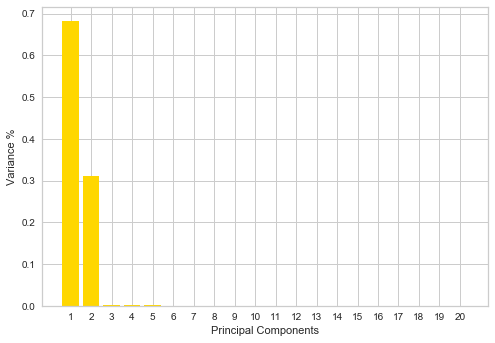

In [54]:
from sklearn.preprocessing import StandardScaler
#std_wine = StandardScaler().fit_transform(filtered_customers)

#pca = PCA(n_components=20)
#principalComponents = pca.fit_transform(filtered_customers)

PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(X_df)

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_df = pca.fit(X).transform(X)
pca.explained_variance_ratio_

array([0.68216184, 0.31064689])

In [56]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [57]:
response_counter(y_test)

(121, 8472)

In [58]:
response_counter(y_train)

(411, 33958)

In [59]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', kernel='sigmoid')
clf.fit(X_train, y_train)

SVC(gamma='auto', kernel='sigmoid')

In [60]:
# Add pipeline for grid search to optimize model
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy : 98.24%


In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8472
           1       0.08      0.02      0.04       121

    accuracy                           0.98      8593
   macro avg       0.53      0.51      0.51      8593
weighted avg       0.97      0.98      0.98      8593



In [62]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average=None)

array([0.98621012, 0.08333333])

In [63]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average=None)

array([0.99610482, 0.02479339])

In [64]:
response_counter(y_pred)

(36, 8557)

## Predicting Purchasing Patterns on Customers

In [65]:
predicted_dataframe_cluster_1 = dataframe_cluster_0.copy()
predicted_dataframe_cluster_2 = dataframe_cluster_1.copy()
predicted_dataframe_cluster_3 = dataframe_cluster_2.copy()

In [66]:
def prediction_function(dataframe):
    dataframe.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'cluster'], axis=1, inplace=True)
    pca = PCA(n_components=2)
    X_component = pca.fit(dataframe).transform(dataframe)
    y_pred = clf.predict(X_component)
    dataframe['prediction'] = y_pred
    number_of_yes, number_of_no = response_counter(dataframe['prediction'])
    print("Number of Purchase Responses: {}".format(number_of_yes))
    print("Percentage of Responses: {:.2f}%".format(number_of_yes/(number_of_yes + number_of_no)))

In [67]:
prediction_function(predicted_dataframe_cluster_1)

Number of Purchase Responses: 9
Percentage of Responses: 0.00%


In [68]:
cluster_2_pred = prediction_function(predicted_dataframe_cluster_2)
cluster_2_pred

Number of Purchase Responses: 7477
Percentage of Responses: 0.07%


In [69]:
cluster_3_pred = prediction_function(predicted_dataframe_cluster_3)
cluster_3_pred

Number of Purchase Responses: 236
Percentage of Responses: 0.02%


## Test Dataset

In [70]:
test_csv = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
test_csv.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [96]:
X = test_csv[:]
# Dropping specific columns with greater than 60% NaN values
X.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4'], axis=1, inplace=True)

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [97]:
X = preprocessing(X)


In [98]:
pca = PCA(n_components=2)
X_df = pca.fit(X).transform(X)

In [99]:
y_pred = clf.predict(X_df)

In [100]:
test_csv['cluster'] = y_pred

In [101]:
test_csv.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4,0
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4,0
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4,0
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4,0
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4,0


### Total Consumer Base

In [90]:
#cleaned_azdias = preprocessing(azdias)
#cleaned_azdias.head()

In [91]:
azdias_df = pca.fit(cleaned_population).transform(cleaned_population)
pca.explained_variance_ratio_

array([0.81129763, 0.18619247])

In [92]:
label2 = k_means_model.fit_predict(azdias_df)

In [93]:
cleaned_population['cluster'] = k_means_model.labels_
cleaned_population.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster,prediction
0,2.0,1.0,18.0,15.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.0,10.0,6.0,9.0,3.0,3,1,2,2,2
1,2.0,9.0,18.0,21.0,11.0,1.0,1.0,2.0,12.0,1.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,2,2
2,2.0,9.0,17.0,17.0,10.0,1.0,1.0,1.0,7.0,1.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,0,0
3,2.0,1.0,13.0,13.0,1.0,1.0,1.0,1.0,2.0,1.0,...,10.0,11.0,6.0,9.0,7.0,3,2,4,0,0
4,2.0,1.0,20.0,14.0,3.0,1.0,1.0,4.0,3.0,1.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,0,0


In [94]:
cleaned_population['prediction'] = label2
number_of_yes_pop, number_of_no_pop = response_counter(cleaned_population['prediction'])
print("Percentage of Responses: {:.2f}%".format(number_of_yes_pop/(number_of_yes_pop + number_of_no_pop)))
print("Number of Purchase Responses: {}".format(number_of_yes_pop))

Percentage of Responses: 0.07%
Number of Purchase Responses: 64954


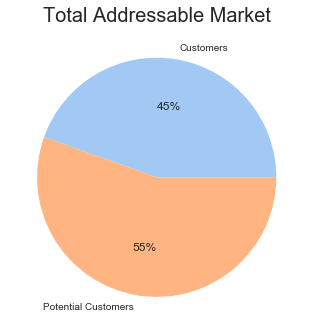

In [95]:
labels = ['Customers', 'Potential Customers']
data = [52135, 64921]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

#create pie chart
plt.title('Total Addressable Market', size = 20)
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

# Conclusion: 

From the data we can conclude that the first cluster has the highest chance of purchasing the mail-order product. These tend to be younger individuals, from area codes where the number of cars is smaller and the number of buildings in the postal codes are fewer than the two other groups of individuals. 

This may hint at the idea that the most likely purchasers of the mail-order product are younger individuals below the ages of 46 and that are living in areas experiencing economic growth as the number of new car manufacturers and buildings are increasing. The data also suggests that this group of people make up the majority of its customers - which is a positive sign. 